## **Dataset visualization and extraction from ESRF .h5 files**
- Version: 1.2 | Author: William Rigaut | Date: 26.11.2024
- Tested on MacOS Ventura 13.4.1 and Python 3.12.3

This code is designed to extract and visualize data from the European Synchrotron Radiation Facility (ESRF) at beamline BM02.

The module contains:
- Functions for extracting and visualizing data from the raw .h5data files
- Functions for extracting and visualizing data from the processed .h5 files
- Functions for saving data to .xy files

### **1. Import library and setup**

Firstly you can create a set of folders where your data will be stored and extracted. I recommand creating a main folder called `ESRF_data` containing three subfolder :
- `RAW_DATA` : Folder contaning the raw XRD data from the 2D camera
- `PROCESSED_DATA` : Folder containing the 1D spectra from integrated 2D images
- `SAVED_DATA` : Output folder containing .xy 1D spectra for each position

In [1]:
# Defining our paths with pathlib librairy
import pathlib as pl

main_folder = "ESRF_data"

raw_data_path = pl.Path(main_folder + '/' + "RAW_DATA")
processed_data_path = pl.Path(main_folder + '/' + "PROCESSED_DATA")
saved_data_path = pl.Path(main_folder + '/' "SAVED_DATA")

Then you can import the package `extract_esrf` to create these folders for you with :

In [2]:
# Making folders with create_folders() function from extract_esrf library
import packages.extract_esrf.extract_esrf as ee

ee.create_folders(main_folder,
                  raw_data_path, processed_data_path, saved_data_path)

Creating folder ESRF_data
Folder ESRF_data already exists.
Creating folder ESRF_data/RAW_DATA
Folder ESRF_data/RAW_DATA already exists.
Creating folder ESRF_data/PROCESSED_DATA
Folder ESRF_data/PROCESSED_DATA already exists.
Creating folder ESRF_data/SAVED_DATA
Folder ESRF_data/SAVED_DATA already exists.


Now that everything is setup you can download or import your raw data files from ESRF in the `RAW_DATA/` and `PROCESSED_DATA/` directories.

<span style="color: red;">Disclamer: You need to have both raw and processed data in order for the notebook to run properly.</span>

### **2. Data visualization and data extraction**

You can define the variable `foldername` to be the folder that contains the data you want to see, here is an example with NdFeB_7-17 dataset for the scan number 31:

In [6]:
foldername="3161_NdFeB"
scan_number=186

Then you can call the function `extract_CdTe_data()` by specifiying both the foldername and the scan_number in argument. A few details about this function :
- The function actually returns an array containing the count on each pixel of the 2D camera. You can eventually save the content of image_2D if needed.
- You can disable the plotting by setting display to False with the code `ee.extract_CdTe_data(foldername, scan_number, display=False)`.
- If you are using a path for the raw data that is different from the one previously suggested you must pass in argument `raw_data_path=your_custom_path` so that the function knows where to look for the data.
- Note that in the 2D camera datasets, the first 26 scans are corresponding to z and theta alignements along the wafer, the first acquired position starts at `scan_number=27` and the last at `scan_number=315`.

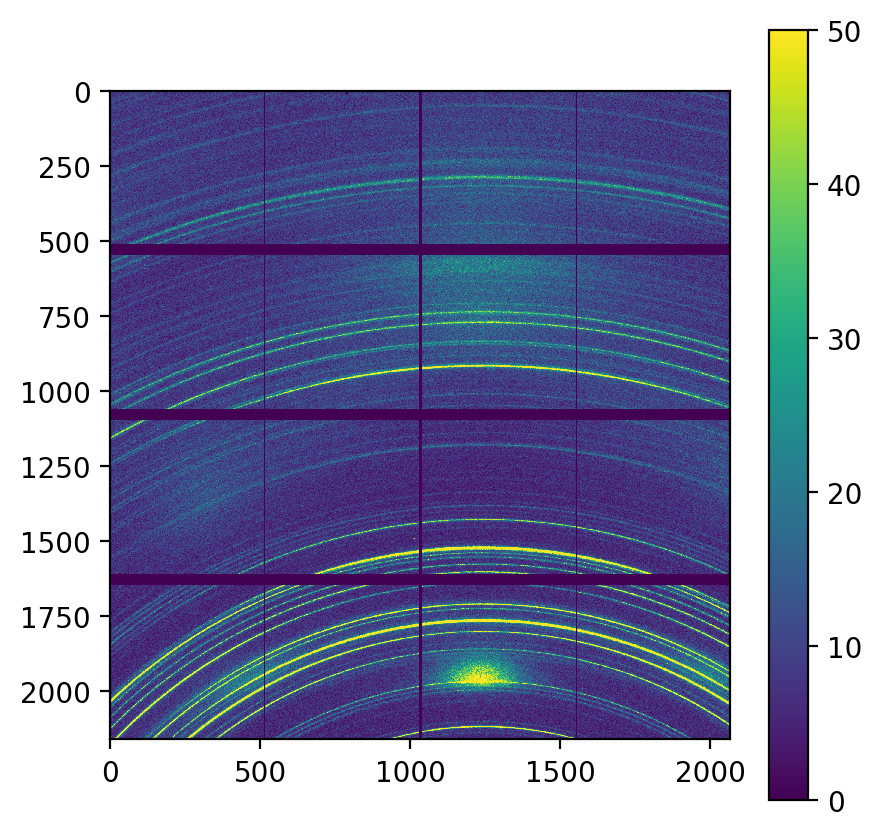

In [7]:
image_2D, metadata = ee.extract_CdTe_data(foldername, scan_number, display=True, output_metadata=True, raw_data_path=raw_data_path)

A very similar `function extract_integrated_data()` can be used to display the 1D integrated image data like this :

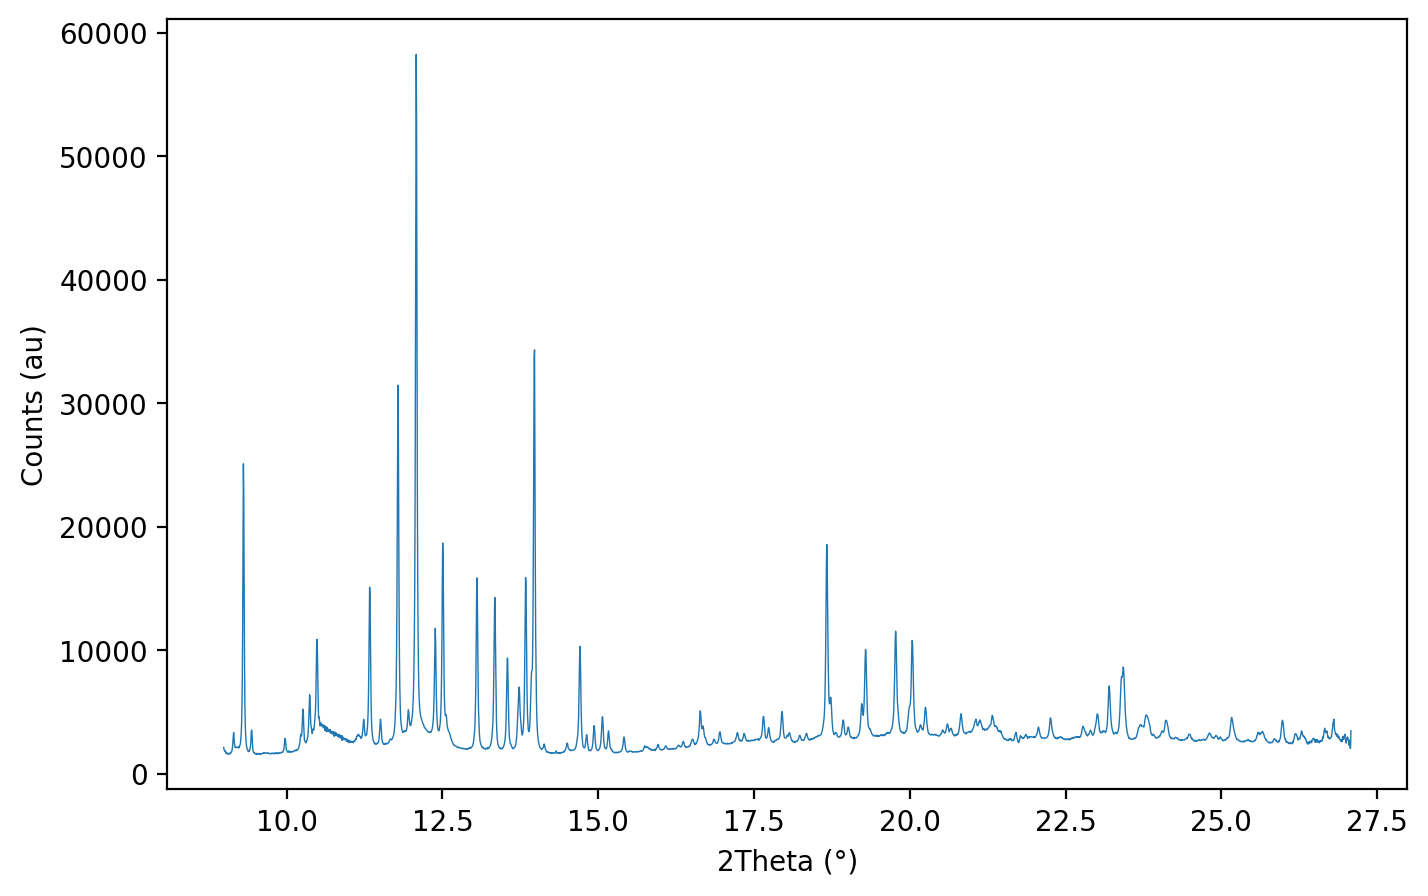

In [8]:
spectra_1D = ee.extract_integrated_data(foldername, scan_number, display=True, processed_data_path=processed_data_path)

You can then simply save the spectra using the function `save_integrated_data()` by passing first both the `foldername` and the `scan_number` as argument to generate a .xy file with a proper filename and then the `spectra_1D` you want to save. A few points :
- The x values saved are q values (in Å^-1) converted to 2θ angle by knowing the beam energy (25 keV).
- In the .h5 integrated data, counts at each angle are calculated by summing all the pixels intensities and normalized by the total number of pixels. In the library, the y values are arbitrary rescaled with a factor of 1000 to make it easier to read in Profex. The final unit for the counts should be counts/pixel*10^3.

In [9]:
ee.save_integrated_data(foldername, scan_number, spectra_1D, saved_data_path=saved_data_path)

If you want to save all the data from the dataset (excluding the calibration points) you can use instead `save_all_integrated()` by specifiying the `foldername` and all three paths `raw_data_path`, `processed_data_path`, `saved_data_path` to the function.

- The function will read all the scans from number 27 to 315 (25 to 274 for new scans), excluding the z and theta scans from calibration
- Metadata is copied from the raw data fils and written in the header of each .xy files.

In [13]:
ee.save_all_integrated(foldername,
    raw_data_path=raw_data_path,
    processed_data_path=processed_data_path,
    saved_data_path=saved_data_path,
    custom_range=range(25, 274))

100%|██████████| 249/249 [00:44<00:00,  5.65it/s]

All .xy spectrum saved in ESRF_data/SAVED_DATA/CeCoZn_4_8 succesfully !


The same can be done with the images using the function `save_all_images()` where you need to pass in arguments the `foldername`, the `raw_data_path` and the `savec_data_path`.

- By default the function will only read measurement data which includes scans from number 27 to 315, but a `custom_range` can be specified using the `range(start, stop)` function.
- The image is saved using the FabIO library, and his saved as .img by default. Format can be changed with the `custom_format` parameter. A list of all FabIO compatible formats can be found here: http://www.silx.org/doc/fabio/latest/getting_started.html#list-of-file-formats-that-fabio-can-read-and-write

In [14]:
ee.save_all_images(
    foldername,
    raw_data_path="./ESRF_data/RAW_DATA/",
    saved_data_path="./ESRF_data/SAVED_DATA/",
    custom_range=range(25, 274))

100%|██████████| 249/249 [01:02<00:00,  3.96it/s]

All CdTe data saved in ESRF_data/SAVED_DATA/CeCoZn_4_8 succesfully !


You can then read the .img files using the `fabio` python module. Here is a advanced example using interactive sliders to display images:

In [10]:
import packages.extract_esrf.extract_esrf as ee

#folderpath_str = "ESRF_data/SAVED_DATA/YFeTa/YFeTa_3_2"
#folderpath_str = "ESRF_data/SAVED_DATA/CeCoX/CeCoZn_4_7"
folderpath_str = "ESRF_data/SAVED_DATA/NdXFeB-triode/3161_NdFeB"
#folderpath_str = "ESRF_data/SAVED_DATA/NdXFeB-magnetron/NdCeFeB_2_7"

img_data_current = ee.display_all_img(folderpath_str, index=113, scale="normal", aspect="1")

interactive(children=(IntSlider(value=113, description='index', max=273, min=25), IntSlider(value=0, descripti…

The follwing function `fuse_all_img()` will merge all of the images in a folder. You can customize the selection with the argument `idx_range`, default value is `range(25, 274)`:

In [3]:
fused_img = ee.fuse_all_img(folderpath_str, idx_range=range(25, 274))


You can use this following code to plot the fused image :

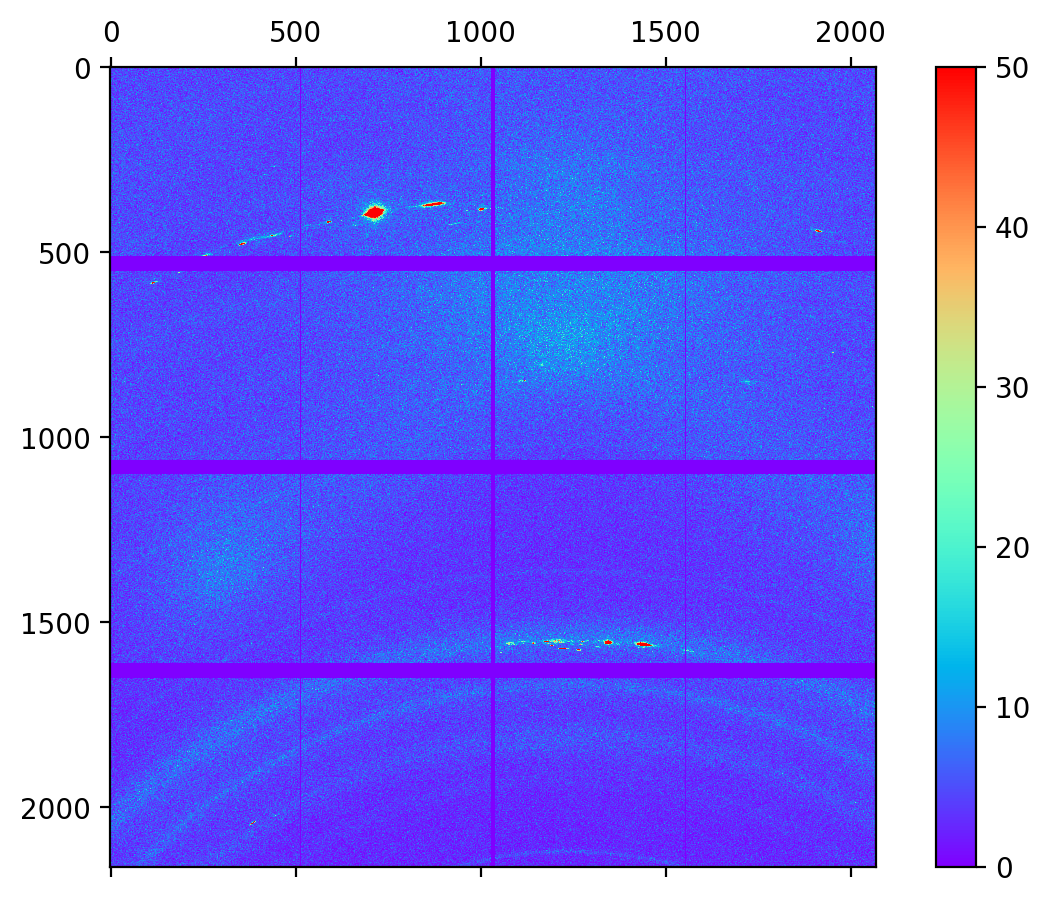

In [1]:
import packages.extract_esrf.extract_esrf as ee
img_data_current = ee.plot_img("ESRF_data/SAVED_DATA/YFeTa/YFeTa_3_2", index=113, plot=False)
ee.plot_img('_', '_', img_data=img_data_current, vmin=0, vmax=50, scale="normal", aspect="1")